# Benchmark: Area computation

Benchmark comparing area computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the area of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```bash
cd harness
cargo build --release
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/relwithdebinfo" target/release/benchmark_area --out-file ../analysis/benchmark_area/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      10.231901    1.261647
std        0.261169    0.019653
min        8.507260    1.190689
25%       10.265279    1.257767
50%       10.298709    1.270308
75%       10.329201    1.274771
max       10.385171    1.278673


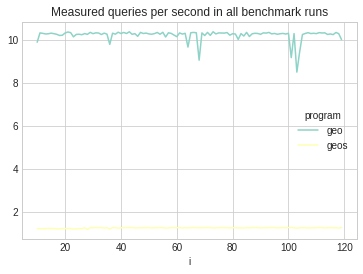

### Statistics: After outlier removal
               qps           
program        geo       geos
count    98.000000  98.000000
mean     10.289585   1.265139
std       0.073788   0.014817
min       9.897458   1.224324
25%      10.272368   1.260434
50%      10.303455   1.270892
75%      10.331243   1.274842
max      10.385171   1.278673


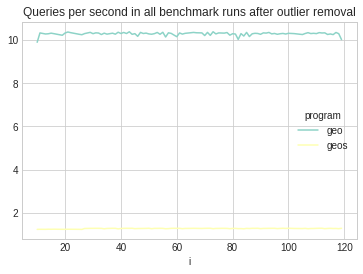

## Ratio of qps compared to geo
               qps
program       geos
count    98.000000
mean      0.122958
std       0.001555
min       0.118841
25%       0.122768
50%       0.123230
75%       0.123739
max       0.127497


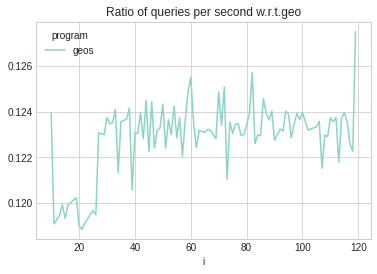

## Ratio of qps compared to geos
               qps
program        geo
count    98.000000
mean      8.134170
std       0.104153
min       7.843349
25%       8.081527
50%       8.114915
75%       8.145429
max       8.414633


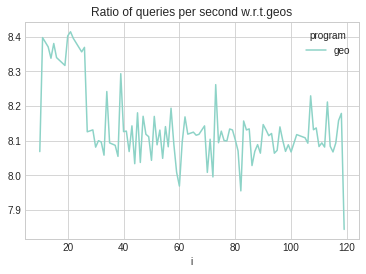

In [38]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb
data_series = series_sans_outliers

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_area/perf.data -- ./target/release/benchmark_area --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_area
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -i perf.data --call-graph=fractal,0.5
```

Observations:
* Over 61% of the time is spent inside `geos::algorithm::Area::ofRingSigned` in libgeos.so - geos area computation proper
  * The descructor `geos::geom::CoordinateArraySequence::~CoordinateArraySequence` in the callgraph is a mystery
* Over 29% of the time is spent inside `geo::algorithm::area::get_linestring_area` -- geo area computation
* geos is *not* slow because of FFI.


# It's the vectors!

Vector iteration is 10x slower than Rust's iterators!

![](./geo_area.png)
![](./geos_area.png)

# Uber-optimized

When building without debug info, gcc -O3 is used. This makes geos faster.

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" target/release/benchmark_area --out-file ../analysis/benchmark_area/data-nodbg.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_area/data-nodbg.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      10.212075    4.502662
std        0.378600    0.104565
min        7.341967    3.768708
25%       10.268325    4.513751
50%       10.304798    4.532483
75%       10.333955    4.547622
max       10.385256    4.569215


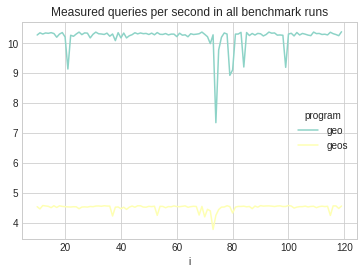

### Statistics: After outlier removal
               qps           
program        geo       geos
count    98.000000  98.000000
mean     10.290620   4.527535
std       0.080152   0.032157
min       9.773720   4.389388
25%      10.273578   4.516781
50%      10.306074   4.535051
75%      10.336065   4.549745
max      10.385256   4.569215


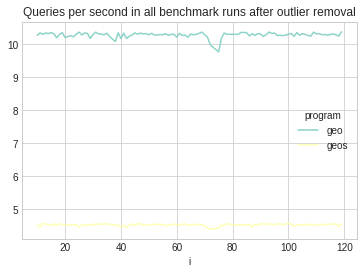

## Ratio of qps compared to geo
               qps
program       geos
count    98.000000
mean      0.439982
std       0.003321
min       0.430000
25%       0.438124
50%       0.440289
75%       0.442216
max       0.453583


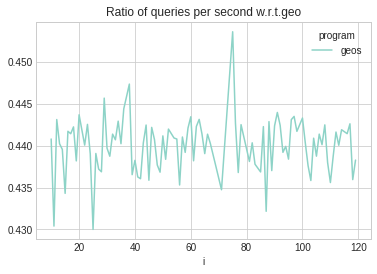

## Ratio of qps compared to geos
               qps
program        geo
count    98.000000
mean      2.272949
std       0.017155
min       2.204667
25%       2.261338
50%       2.271236
75%       2.282460
max       2.325583


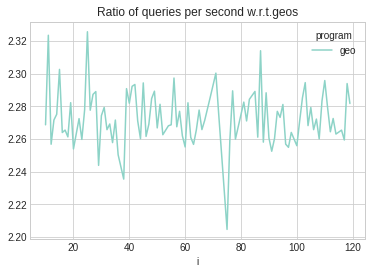

In [39]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data-nodbg.json')
%run ../common/benchmark_analysis.ipynb

# Uber optimized geos - perf analysis.

Generate with:

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" perf record -F 300 -g --call-graph dwarf -o ../analysis/benchmark_area/perf-nodbg.data -- ./target/release/benchmark_area --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null
```

Snippet from

```bash
perf report -i perf-nodbg.data --call-graph=fractal,0.5
```

![](./geos_area_still_iteration.png)

Qualitatively unchanged. Less symbols, but largest time is still taken by the same iteration path

# Root cause

Histograms (with global timeshare shown):

<pre>
-    9.85%     0.22%  benchmark_area  benchmark_area  [.] benchmark_area::geo_area
     9.63% benchmark_area::geo_area
        <geo_types::multi_polygon::MultiPolygon<T> as geo::algorithm::area::Area<T>>::signed_area (inlined)
        core::iter::traits::iterator::Iterator::fold (inlined)
        _$LT$geo_types..multi_polygon..MultiPolygon$LT$T$GT$$u20$as$u20$geo..algorithm..area..Area$LT$T$GT$$GT$::signed_area::_$u7b$$u7b$closure$u7d$$u7d$::h7499759712fc2893 (inlined)
        <geo_types::polygon::Polygon<T> as geo::algorithm::area::Area<T>>::signed_area (inlined)
        geo::algorithm::area::get_linestring_area
      - geo::algorithm::area::twice_signed_ring_area (inlined)
         - 5.14% <core::iter::adapters::map::Map<I,F> as core::iter::traits::iterator::Iterator>::next (inlined)
            - 2.95% core::option::Option<T>::map (inlined)
                 core::ops::function::impls::<impl core::ops::function::FnOnce<A> for &mut F>::call_once (inlined)
                 geo_types::line_string::LineString$LT$T$GT$::lines::_$u7b$$u7b$closure$u7d$$u7d$::h56776f40cf098343 (inlined)
              2.19% <core::slice::iter::Windows<T> as core::iter::traits::iterator::Iterator>::next (inlined)
         - 2.63% geo_types::line::Line<T>::determinant (inlined)
              <f64 as core::ops::arith::Sub>::sub (inlined)
         - 1.86% <geo_types::line::Line<T> as geo::algorithm::map_coords::MapCoords<T,NT>>::map_coords (inlined)
              <geo_types::point::Point<T> as geo::algorithm::map_coords::MapCoords<T,NT>>::map_coords (inlined)
              geo::algorithm::area::twice_signed_ring_area::_$u7b$$u7b$closure$u7d$$u7d$::hac06ea9fa53ccbc4 (inlined)
              <f64 as core::ops::arith::Sub>::sub (inlined)
</pre>

<pre>
-   78.45%     0.00%  benchmark_area  benchmark_area  [.] benchmark_area::geos_area
     benchmark_area::geos_area
     <geos::geometry::Geometry as geos::geometry::Geom>::area
     GEOSArea_r
   - execute<GEOSArea_r::{lambda()#1}>
      - GEOSArea_r::{lambda()#1}::operator()
         - geos::geom::GeometryCollection::getArea
            - 78.12% geos::geom::Polygon::getArea
               - 77.46% geos::algorithm::Area::ofRing
                  - 77.24% geos::algorithm::Area::ofRingSigned
                     - 19.15% geos::geom::CoordinateArraySequence::getAt
                          10.39% std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]
                          1.53% std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]@plt
               - 0.55% geos::geom::LineString::getCoordinatesRO
                    std::unique_ptr<geos::geom::CoordinateSequence, std::default_delete<geos::geom::CoordinateSequence> >::get
                    std::__uniq_ptr_impl<geos::geom::CoordinateSequence, std::default_delete<geos::geom::CoordinateSequence> >::_M_ptr

</pre>

There are two large sources of the difference.

77% of the time is spent inside geos::algorithm::Area::ofRingSigned. Of this,
~20% is in a geos::geom::CoordinateArraySequence::getAt. So 50% is in calculations
are in geos::algorithm::Area::ofRingSigned

Most of this time is spent in [calculation of the area proper](./geos::algorithm::Area::ofRingSigned.annotation):

<pre>
                     p2.x -= x0;
  1.20         movsd  -0x80(%rbp),%xmm0
  2.41         subsd  -0x20(%rbp),%xmm0
 10.18         movsd  %xmm0,-0x80(%rbp)
                     sum += p1.x * (p0.y - p2.y);
  2.63         movsd  -0x60(%rbp),%xmm1
               movsd  -0x38(%rbp),%xmm0
               movsd  -0x78(%rbp),%xmm2
               subsd  %xmm2,%xmm0
  2.52         mulsd  %xmm1,%xmm0
  6.46         movsd  -0x8(%rbp),%xmm1
               addsd  %xmm1,%xmm0
 11.71         movsd  %xmm0,-0x8(%rbp)
</pre>

Compared to this, benchmark_area::geo_area accounts for 9.63% of global timeshare
Of this, core::iter::traits::iterator::Iterator>::next accounts for ~5%, so only
~5% of the time is spent in [equivalent area computation as above](./geo::algorithm::area::get_linestring_area.annotation):

<pre>
              mulpd  %xmm2,%xmm4
             _ZN45_$LT$f64$u20$as$u20$core..ops..arith..Sub$GT$3sub17h7b8b1be7ea3e7a7aE():
  1.86         movapd %xmm4,%xmm2
               unpckhpd %xmm4,%xmm2
               subsd  %xmm2,%xmm4
             _ZN45_$LT$f64$u20$as$u20$core..ops..arith..Add$GT$3add17hc97f37a33d9f3bdcE():
               addsd  %xmm0,%xmm4
             _ZN9geo_types11line_string19LineString$LT$T$GT$5lines28_$u7b$$u7b$closure$u7d$$u7d$17h56776f40cf098343E():
  3.06         movupd (%rax),%xmm0
             _ZN106_$LT$core..ops..range..Range$LT$usize$GT$$u20$as$u20$core..slice..index..SliceIndex$LT$$u5b$T$u5d$$GT$$GT$13get_unchecked17h00ddc2259fd66df5E():

</pre>

The key difference is the use of [movsd](https://c9x.me/x86/html/file_module_x86_id_204.html) instruction in geos (accounts for over 20% of total time) vs [movapd](https://c9x.me/x86/html/file_module_x86_id_179.html) and friends in geo.

The Rust compiler successfully vectorizes the computations!

The second source of difference is geos::geom::CoordinateArraySequence::getAt (20%) vs core::iter::traits::iterator::Iterator>::next (5%). Rust compiler is able to generate
far simpler machine code for iteration than C++ vectors.

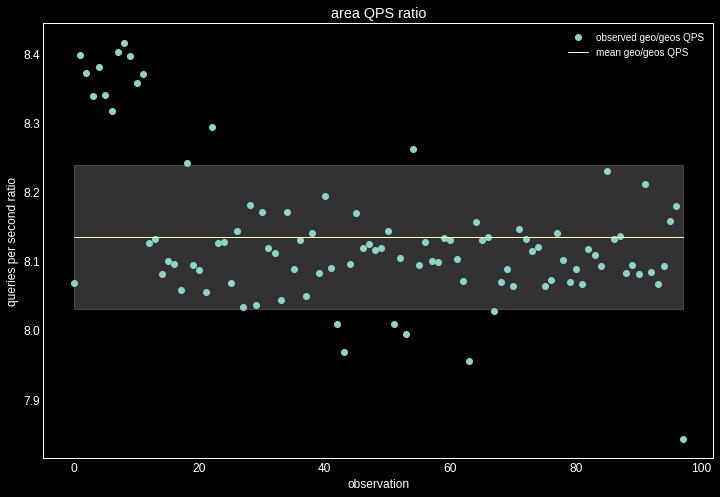

In [40]:
series_geo = data_series.iloc[:, 0]
assert series_geo.name == ('qps', 'geo')
series_geos = data_series.iloc[:, 1]
assert series_geos.name == ('qps', 'geos')

ratio = series_geo.divide(series_geos)

plt.style.use('dark_background')

@plt.rc_context({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'image.cmap': plt.get_cmap('Pastel1'),
})
def initialize_plot():
    fig = plt.figure()
    return fig.add_subplot(title='area QPS ratio')

x = range(ratio.size)
ax = initialize_plot()
ax.plot(x, ratio, linewidth=0, marker='o', label='observed geo/geos QPS')
ax.plot(x, [ratio.mean()] * ratio.size, linewidth=1, label='mean geo/geos QPS')
ax.fill_between(x, ratio.mean() - ratio.std(), ratio.mean() + ratio.std(), alpha=0.2, color='white')
ax.legend()
ax.set_xlabel('observation')
ax.set_ylabel('queries per second ratio')
ax.grid(False)
plt.savefig('area_qps_ratio.svg', transparent=True)